# Parallel vs. Serial Performance Analysis of Hyperparameter Grid Search in Gradient Descent
# 06/09/20

In [2]:
import math
import subprocess
import sys
import os
import timeit
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Define input variables:

$P$ = array of file names

$N$ = array of number of threads

In [135]:
P = [500, 100000, 300000, 1000000, 5000000]
N = [0,1,2,4,6,8]
in_path_arr = ["trainingData_500.csv", "trainingData_100000.csv", "trainingData_300000.csv", 
               "trainingData_1000000.csv", "trainingData_5000000.csv"]
sample_size_arr = ["sample = 500", "sample = 100k", "sample = 300k", "sample = 1m", "sample = 5m"]
blockSize = 2

In [148]:
def generate_data(P):
    filepath_calibrate = "C:\\Users\\eddie\\Documents\\MSCS\\ParallelProgramming\\eddieshim\\proj3\\calibrate\\"
    for p in P:
        command = "go run {}calibrate.go -g={}".format(filepath_calibrate,p)
        process = subprocess.Popen(["powershell.exe", command], stdout = subprocess.PIPE, stderr = subprocess.STDOUT)
        print(command)

In [149]:
os.chdir("C:\\Users\\eddie\\Documents\\MSCS\\ParallelProgramming\\eddieshim\\proj3\\training_data")
os.getcwd()
generate_data(P)

go run C:\Users\eddie\Documents\MSCS\ParallelProgramming\eddieshim\proj3\calibrate\calibrate.go -g=500
go run C:\Users\eddie\Documents\MSCS\ParallelProgramming\eddieshim\proj3\calibrate\calibrate.go -g=100000
go run C:\Users\eddie\Documents\MSCS\ParallelProgramming\eddieshim\proj3\calibrate\calibrate.go -g=300000
go run C:\Users\eddie\Documents\MSCS\ParallelProgramming\eddieshim\proj3\calibrate\calibrate.go -g=1000000
go run C:\Users\eddie\Documents\MSCS\ParallelProgramming\eddieshim\proj3\calibrate\calibrate.go -g=5000000


In [130]:
os.chdir("C:\\Users\\eddie\\Documents\\MSCS\\ParallelProgramming\\eddieshim\\proj3\\output")
os.getcwd()

'C:\\Users\\eddie\\Documents\\MSCS\\ParallelProgramming\\eddieshim\\proj3\\output'

In [164]:
#function that uses Windows Powershell terminal in order to execute our editor.go script in parallel or serial
def run_calibrate(numThreads, blockSize, inpath):
    fp = "C:\\Users\\eddie\\Documents\\MSCS\\ParallelProgramming\\eddieshim\\proj3\\"
    args = ""
        
    command = "Get-Content {}hyperparams.txt | go run {}calibrate\\calibrate.go -t={} -b={} -i=\"{}\\training_data\\{}\"".format(fp, fp, numThreads, 
                                                                                                 blockSize, fp,inpath)
    time_command = "Measure-Command{" +  command + "}  | Select-Object -Property TotalSeconds"
#     print(time_command)
    process = subprocess.Popen(["powershell.exe", time_command], stdout = subprocess.PIPE, stderr = subprocess.STDOUT)
    terminal_output = str(process.communicate()[0])    
    exec_output = round(float(re.findall("\d+\.\d+", terminal_output)[0]), 2)
    return(exec_output)    

In [171]:
all_results = []
for fp in in_path_arr:
    avg_times = []
    sample_n = 5
    for n in N:
        avg_thread_time = 0
        for j in range(0, sample_n):
            single_time = run_calibrate(n, blockSize, fp)
#             print("Ran thread num =", n, "file =", fp, "| single time =", single_time)
            avg_thread_time += single_time
        avg_thread_time = np.divide(avg_thread_time, sample_n)
        print("Ran thread num =", n, "file =", fp, "| avg time =", avg_thread_time)
        avg_times.append(avg_thread_time)
    all_results.append(avg_times)
print(all_results)

Ran thread num = 0 file = trainingData_500.csv | avg time = 9.4
Ran thread num = 1 file = trainingData_500.csv | avg time = 1.07
Ran thread num = 2 file = trainingData_500.csv | avg time = 1.06
Ran thread num = 4 file = trainingData_500.csv | avg time = 0.98
Ran thread num = 6 file = trainingData_500.csv | avg time = 0.98
Ran thread num = 8 file = trainingData_500.csv | avg time = 0.98
Ran thread num = 0 file = trainingData_100000.csv | avg time = 25.89
Ran thread num = 1 file = trainingData_100000.csv | avg time = 17.89
Ran thread num = 2 file = trainingData_100000.csv | avg time = 13.17
Ran thread num = 4 file = trainingData_100000.csv | avg time = 14.37
Ran thread num = 6 file = trainingData_100000.csv | avg time = 13.66
Ran thread num = 8 file = trainingData_100000.csv | avg time = 12.94
Ran thread num = 0 file = trainingData_300000.csv | avg time = 64.98
Ran thread num = 1 file = trainingData_300000.csv | avg time = 54.74
Ran thread num = 2 file = trainingData_300000.csv | avg tim

Defining speed up as:

$$speedup = \frac{\text{wall-clock time of serial execution}}{\text{wall-clock time of parallel execution}}$$

In [172]:
speedup_df = pd.DataFrame(columns = [sample_size_arr])
for file_index in range(0, len(all_results)):
    avg_times = all_results[file_index]
    seq_time = avg_times[0]
    speedup_times = []
    for i in range(1,len(avg_times)):
         speedup_times.append(np.divide(seq_time, avg_times[i]))
    speedup_df[sample_size_arr[file_index]] = speedup_times
    speedup_df.index = N[1:]
    speedup_df.index.names = ["numThreads"]
print(speedup_df)
        

           sample = 500 sample = 100k sample = 300k sample = 1m sample = 5m
numThreads                                                                 
1              8.785047      1.447177      1.187066    1.068760    1.001144
2              8.867925      1.965831      1.536897    1.601821    1.412739
4              9.591837      1.801670      1.562019    1.513468    1.736966
6              9.591837      1.895315      1.742558    1.708231    1.863002
8              9.591837      2.000773      1.781738    1.709938    1.438419


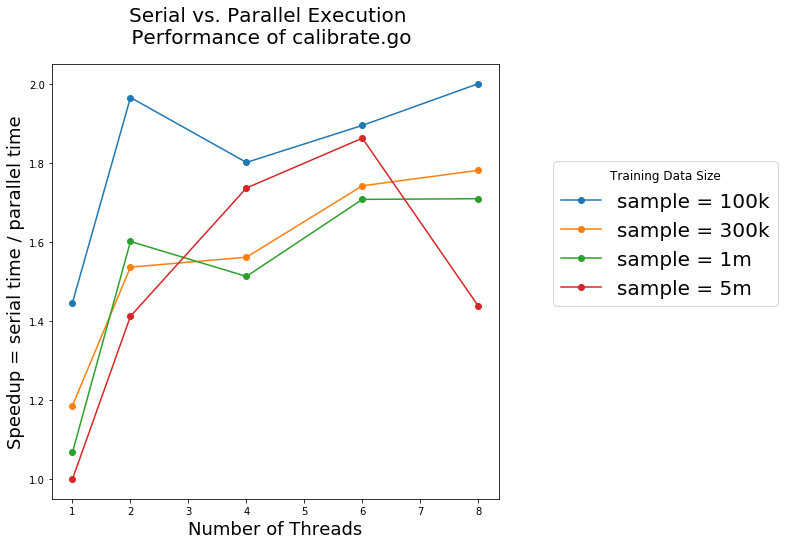

In [174]:
fig, ax = plt.subplots()
for s in sample_size_arr[1:]:
    plt.plot(s, data = speedup_df, marker = 'o')
plt.xlabel("Number of Threads", fontsize = 18)
plt.ylabel("Speedup = serial time / parallel time", fontsize = 18)
# plt.yticks(np.arange(0, 3, .25))
# plt.xticks(np.arange(0, 10, 1))
plt.suptitle("Serial vs. Parallel Execution\n Performance of calibrate.go", fontsize = 20)
plt.rcParams["figure.figsize"]=(8,8)
plt.legend(bbox_to_anchor = (1.1,.8), prop = {"size": 20}, title = "Training Data Size")
plt.rcParams['legend.title_fontsize'] = 'large'
